In [5]:
# Uncomment and run the following lines if you need to install any libraries
# !pip install pandas numpy scikit-learn matplotlib seaborn joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from joblib import dump, load
import datetime

# For better plot aesthetics
sns.set(style="whitegrid")


In [6]:
# Load the training data
train_data = pd.read_csv('Train_Data_Set.csv')

# Load the testing data
test_data = pd.read_csv('Test_Data_Set.csv')

# Display the first few rows to verify
print("Training Data Sample:")
print(train_data.head())

print("\nTesting Data Sample:")
print(test_data.head())


Training Data Sample:
            Time  TOTAL_ACTIVE_POWER  Irradiation  Temp  Wind  Humidity  \
0  3/1/2023 0:00                 0.0          0.0  25.0   4.0      0.89   
1  3/1/2023 0:01                 0.0          0.0  25.0   4.0      0.89   
2  3/1/2023 0:02                 0.0          0.0  25.0   4.0      0.89   
3  3/1/2023 0:03                 0.0          0.0  25.0   4.0      0.89   
4  3/1/2023 0:04                 0.0          0.0  25.0   4.0      0.89   

   Barometer  
0     1013.0  
1     1013.0  
2     1013.0  
3     1013.0  
4     1013.0  

Testing Data Sample:
              Time  TOTAL_ACTIVE_POWER  Irradiation  Temp  Wind  Humidity  \
0  10/16/2023 0:00                 0.0          0.0  25.0  6.00      0.94   
1  10/16/2023 0:01                 0.0          0.0  25.0  5.95      0.94   
2  10/16/2023 0:02                 0.0          0.0  25.0  5.90      0.94   
3  10/16/2023 0:03                 0.0          0.0  25.0  5.85      0.94   
4  10/16/2023 0:04            

In [7]:
def combine_date_time(df):
    """
    Combines 'Date' and 'Time' columns into a single 'Datetime' column.
    Assumes 'Time' column contains both date and time.
    """
    # Split 'Time' into separate 'Date' and 'Time' if necessary
    if 'Date' not in df.columns:
        df[['Date', 'Time']] = df['Time'].str.split(' ', n=1, expand=True)

    # Convert 'Date' and 'Time' to datetime
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%m/%d/%Y %H:%M')

    # Drop original 'Date' and 'Time' columns
    df = df.drop(['Date', 'Time'], axis=1)

    return df

# Apply to training and testing data
train_data = combine_date_time(train_data)
test_data = combine_date_time(test_data)

# Verify the new 'Datetime' column
print("\nTraining Data with Datetime:")
print(train_data.head())

print("\nTesting Data with Datetime:")
print(test_data.head())



Training Data with Datetime:
   TOTAL_ACTIVE_POWER  Irradiation  Temp  Wind  Humidity  Barometer  \
0                 0.0          0.0  25.0   4.0      0.89     1013.0   
1                 0.0          0.0  25.0   4.0      0.89     1013.0   
2                 0.0          0.0  25.0   4.0      0.89     1013.0   
3                 0.0          0.0  25.0   4.0      0.89     1013.0   
4                 0.0          0.0  25.0   4.0      0.89     1013.0   

             Datetime  
0 2023-03-01 00:00:00  
1 2023-03-01 00:01:00  
2 2023-03-01 00:02:00  
3 2023-03-01 00:03:00  
4 2023-03-01 00:04:00  

Testing Data with Datetime:
   TOTAL_ACTIVE_POWER  Irradiation  Temp  Wind  Humidity    Barometer  \
0                 0.0          0.0  25.0  6.00      0.94  1011.666667   
1                 0.0          0.0  25.0  5.95      0.94  1011.650000   
2                 0.0          0.0  25.0  5.90      0.94  1011.633333   
3                 0.0          0.0  25.0  5.85      0.94  1011.616667   
4    

In [8]:
# Sort the data by 'Datetime'
train_data = train_data.sort_values('Datetime').reset_index(drop=True)
test_data = test_data.sort_values('Datetime').reset_index(drop=True)


In [9]:
# Shift 'TOTAL_ACTIVE_POWER' by -15 to create the target variable
train_data['Target'] = train_data['TOTAL_ACTIVE_POWER'].shift(-15)
test_data['Target'] = test_data['TOTAL_ACTIVE_POWER'].shift(-15)

# Drop the last 15 rows which have NaN in 'Target'
train_data = train_data.dropna().reset_index(drop=True)
test_data = test_data.dropna().reset_index(drop=True)

# Verify the target
print("\nTraining Data with Target:")
print(train_data[['Datetime', 'TOTAL_ACTIVE_POWER', 'Target']].head())



Training Data with Target:
             Datetime  TOTAL_ACTIVE_POWER  Target
0 2023-03-01 00:00:00                 0.0     0.0
1 2023-03-01 00:01:00                 0.0     0.0
2 2023-03-01 00:02:00                 0.0     0.0
3 2023-03-01 00:03:00                 0.0     0.0
4 2023-03-01 00:04:00                 0.0     0.0


In [10]:
def extract_time_features(df):
    df['Hour'] = df['Datetime'].dt.hour
    df['Minute'] = df['Datetime'].dt.minute
    df['Day'] = df['Datetime'].dt.day
    df['Month'] = df['Datetime'].dt.month
    df['DayOfWeek'] = df['Datetime'].dt.dayofweek  # Monday=0, Sunday=6
    return df

train_data = extract_time_features(train_data)
test_data = extract_time_features(test_data)

# Verify the new features
print("\nTraining Data with Time Features:")
print(train_data.head())



Training Data with Time Features:
   TOTAL_ACTIVE_POWER  Irradiation  Temp  Wind  Humidity  Barometer  \
0                 0.0          0.0  25.0   4.0      0.89     1013.0   
1                 0.0          0.0  25.0   4.0      0.89     1013.0   
2                 0.0          0.0  25.0   4.0      0.89     1013.0   
3                 0.0          0.0  25.0   4.0      0.89     1013.0   
4                 0.0          0.0  25.0   4.0      0.89     1013.0   

             Datetime  Target  Hour  Minute  Day  Month  DayOfWeek  
0 2023-03-01 00:00:00     0.0     0       0    1      3          2  
1 2023-03-01 00:01:00     0.0     0       1    1      3          2  
2 2023-03-01 00:02:00     0.0     0       2    1      3          2  
3 2023-03-01 00:03:00     0.0     0       3    1      3          2  
4 2023-03-01 00:04:00     0.0     0       4    1      3          2  


In [11]:
# Define feature columns
feature_cols = ['Irradiation', 'Temp', 'Wind', 'Humidity', 'Barometer',
               'Hour', 'Minute', 'Day', 'Month', 'DayOfWeek']

# Features and target for training
X_train = train_data[feature_cols]
y_train = train_data['Target']
# Features and target for testing
X_test = test_data[feature_cols]
y_test = test_data['Target']


In [12]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=700, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

print("\nRandom Forest model trained successfully.")



Random Forest model trained successfully.


In [13]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")



Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.8515
Mean Squared Error (MSE): 3.0274
Root Mean Squared Error (RMSE): 1.7399
R-squared (R²): 0.6580


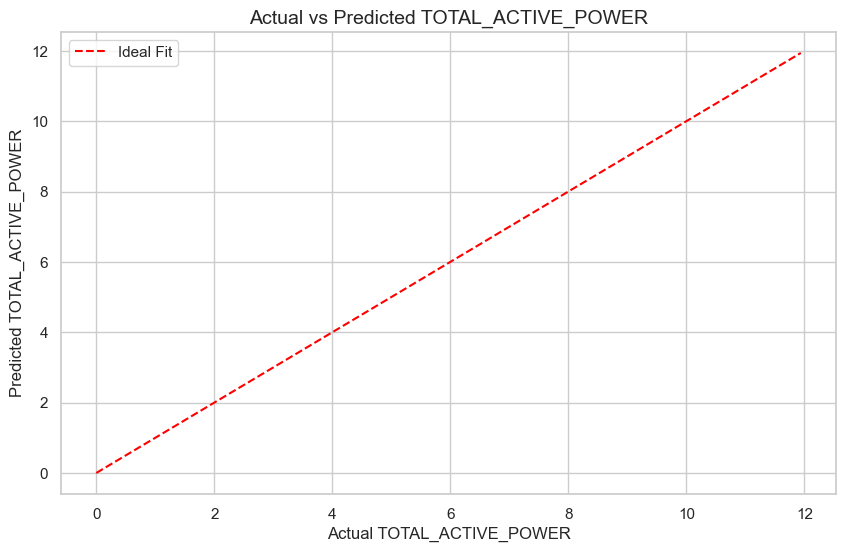

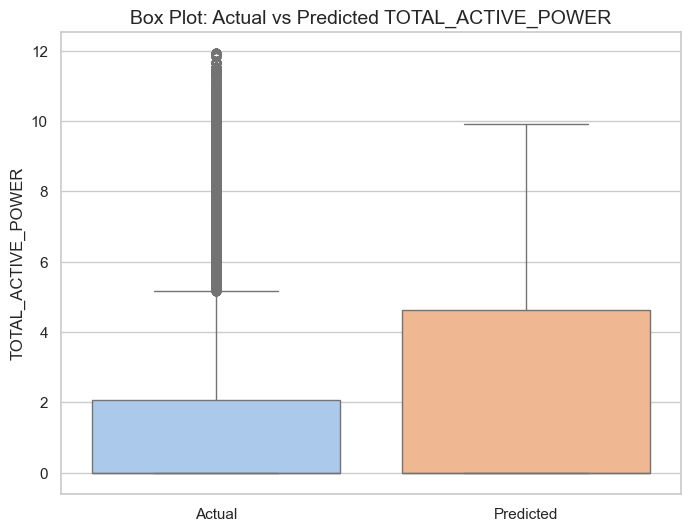

In [14]:

plt.figure(figsize=(10, 6))

# Diagonal line for ideal predictions
max_val = max(y_test.max(), y_pred.max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Ideal Fit')

plt.title('Actual vs Predicted TOTAL_ACTIVE_POWER', fontsize=14)
plt.xlabel('Actual TOTAL_ACTIVE_POWER', fontsize=12)
plt.ylabel('Predicted TOTAL_ACTIVE_POWER', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data=pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}), palette='pastel')
plt.title('Box Plot: Actual vs Predicted TOTAL_ACTIVE_POWER', fontsize=14)
plt.ylabel('TOTAL_ACTIVE_POWER', fontsize=12)
plt.show()


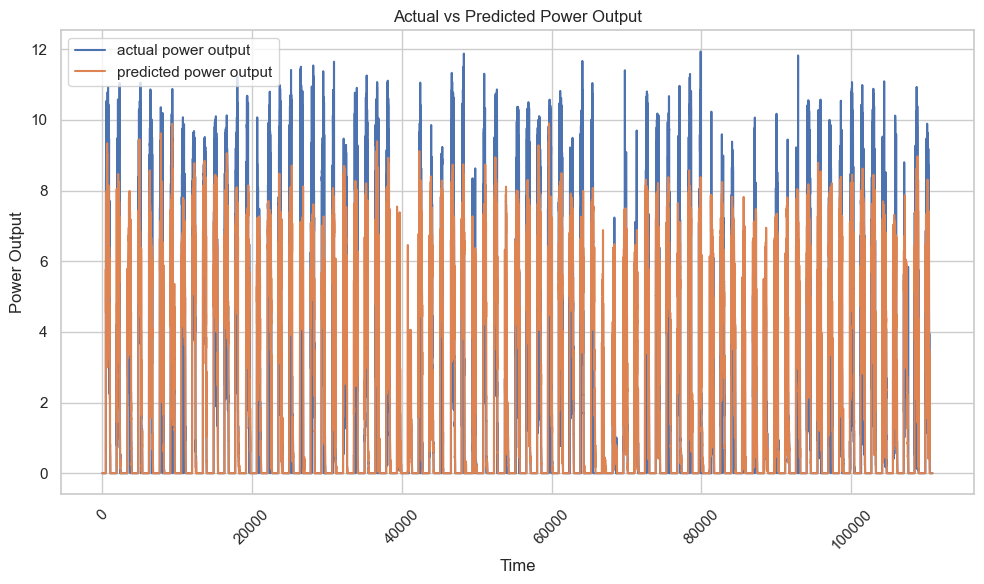

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="actual power output")
plt.plot(y_pred, label="predicted power output")
plt.title("Actual vs Predicted Power Output")
plt.xlabel("Time")
plt.ylabel("Power Output")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# Save the trained model to a file
model_filename = 'RandomForest_TotalPowerOutput_15min.joblib'
dump(rf_model, model_filename)
print(f"\nModel saved as '{model_filename}'")



Model saved as 'RandomForest_TotalPowerOutput_15min.joblib'


In [17]:
def predict_next_15_minutes(model, custom_input):
    """
    Predict the Total Power Output for the next 15 minutes at 1-minute intervals.

    Parameters:
    - model: Trained Random Forest model.
    - custom_input: Dictionary containing input features.

    Returns:
    - DataFrame containing predictions for the next 15 minutes.
    """
    predictions = []
    current_input = custom_input.copy()

    for i in range(15):
        # Convert current input to DataFrame
        input_df = pd.DataFrame([current_input])

        # Extract datetime features
        input_df['Hour'] = input_df['Datetime'].dt.hour
        input_df['Minute'] = input_df['Datetime'].dt.minute
        input_df['Day'] = input_df['Datetime'].dt.day
        input_df['Month'] = input_df['Datetime'].dt.month
        input_df['DayOfWeek'] = input_df['Datetime'].dt.dayofweek

        # Select features
        input_features = ['Irradiation', 'Temp', 'Wind', 'Humidity', 'Barometer',
                          'Hour', 'Minute', 'Day', 'Month', 'DayOfWeek']
        X_new = input_df[feature_cols]

        # Make prediction
        pred = model.predict(X_new)[0]
        predictions.append(pred)

        # Update the datetime for the next prediction
        next_datetime = input_df['Datetime'][0] + pd.Timedelta(minutes=1)

        # Update custom_input for the next iteration
        current_input = {
            'Irradiation': input_df['Irradiation'][0],
            'Temp': input_df['Temp'][0],
            'Wind': input_df['Wind'][0],
            'Humidity': input_df['Humidity'][0],
            'Barometer': input_df['Barometer'][0],
            'Datetime': next_datetime
        }

    # Create a DataFrame for predictions
    prediction_times = [custom_input['Datetime'] + pd.Timedelta(minutes=i+1) for i in range(15)]
    prediction_df = pd.DataFrame({
        'Datetime': prediction_times,
        'Predicted_TOTAL_ACTIVE_POWER': predictions
    })

    return prediction_df


In [18]:
# Load the saved model
loaded_model = load('RandomForest_TotalPowerOutput_15min.joblib')

# Define custom input
custom_input = {
    'Irradiation': 615,
    'Temp': 30,
    'Wind': 9,
    'Humidity': 0.803,
    'Barometer': 1010.0,
    'Datetime': pd.to_datetime('2023-10-20 10:10:00')  # Exact date and time
}

# Make predictions for the next 15 minutes
predicted_df = predict_next_15_minutes(loaded_model, custom_input)
print("\nPredicted TOTAL_ACTIVE_POWER for the next 15 minutes:")
print(predicted_df)



Predicted TOTAL_ACTIVE_POWER for the next 15 minutes:
              Datetime  Predicted_TOTAL_ACTIVE_POWER
0  2023-10-20 10:11:00                      7.112702
1  2023-10-20 10:12:00                      7.057190
2  2023-10-20 10:13:00                      7.098378
3  2023-10-20 10:14:00                      7.111859
4  2023-10-20 10:15:00                      7.062734
5  2023-10-20 10:16:00                      7.048380
6  2023-10-20 10:17:00                      7.140954
7  2023-10-20 10:18:00                      7.151257
8  2023-10-20 10:19:00                      7.141328
9  2023-10-20 10:20:00                      7.068117
10 2023-10-20 10:21:00                      6.998000
11 2023-10-20 10:22:00                      6.952467
12 2023-10-20 10:23:00                      6.952290
13 2023-10-20 10:24:00                      6.952890
14 2023-10-20 10:25:00                      6.961073


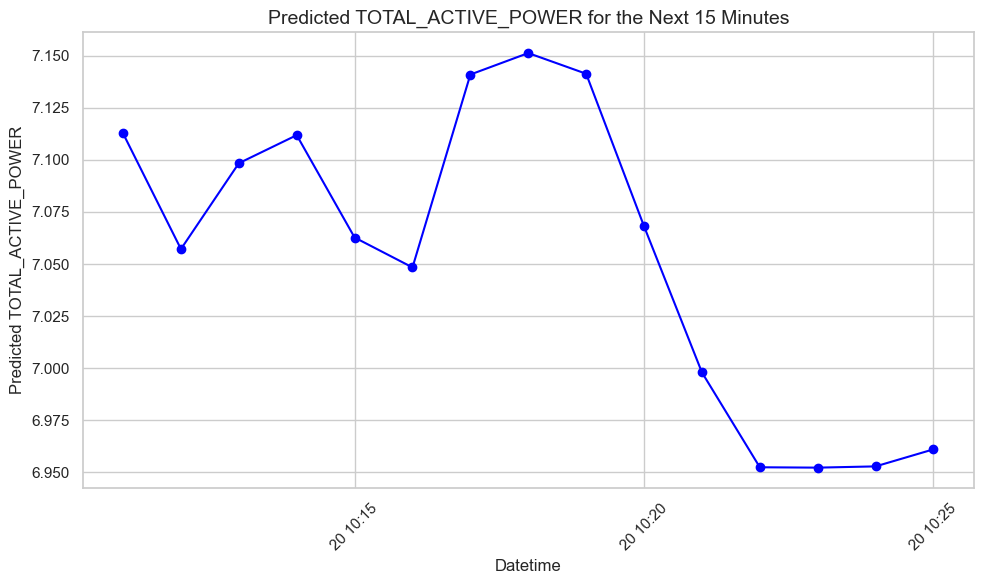

In [19]:
# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(predicted_df['Datetime'], predicted_df['Predicted_TOTAL_ACTIVE_POWER'], marker='o', linestyle='-', color='blue')

plt.title('Predicted TOTAL_ACTIVE_POWER for the Next 15 Minutes', fontsize=14)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Predicted TOTAL_ACTIVE_POWER', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


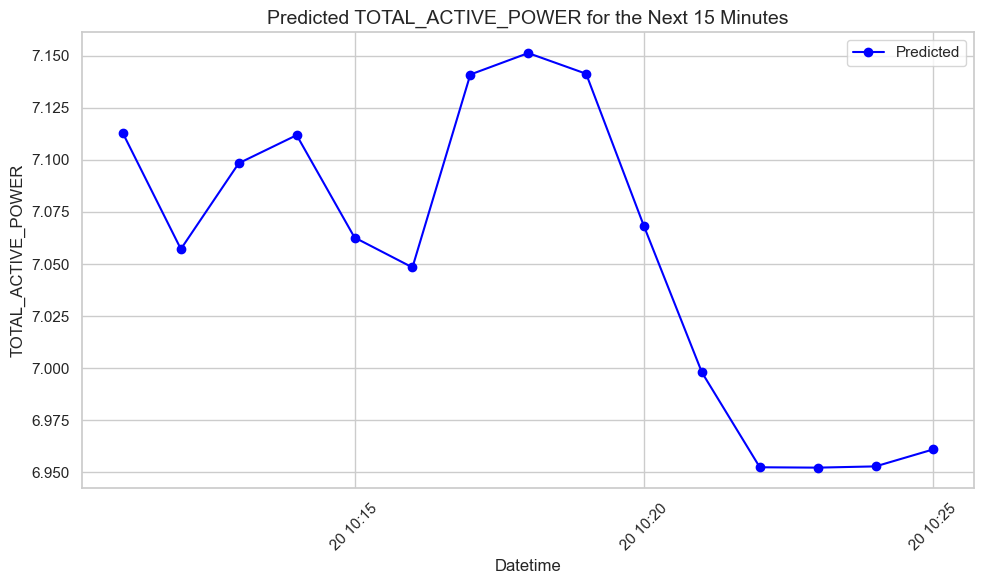

In [20]:
# Assuming you have actual values for the next 15 minutes in your test set
# For demonstration, we'll append the predictions to the test_data

# Select the last timestamp from test_data
last_datetime = test_data['Datetime'].iloc[-1]

# Create a DataFrame to hold actual and predicted values
# Here, we assume actual values are not available; replace 'Actual' with real data if available
combined_df = predicted_df.copy()
combined_df['Actual_TOTAL_ACTIVE_POWER'] = np.nan  # Placeholder for actual values

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(combined_df['Datetime'], combined_df['Predicted_TOTAL_ACTIVE_POWER'], marker='o', linestyle='-', color='blue', label='Predicted')
plt.title('Predicted TOTAL_ACTIVE_POWER for the Next 15 Minutes', fontsize=14)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('TOTAL_ACTIVE_POWER', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
